# Exercise: Parallel Monte Carlo (Threads)

**Note: You should use multiple Julia threads for this exercise!**

In [13]:
using Base.Threads
@assert Threads.nthreads() > 1
Threads.nthreads()

4

Calculate the value of $\pi$ through parallel direct Monte Carlo.

A unit circle is inscribed inside a unit square with side length 2 (from -1 to 1). The area of the circle is $\pi$, the area of the square is 4, and the ratio is $\pi/4$. This means that, if you throw $N$ darts randomly at the square, approximately $M=N\pi/4$ of those darts will land inside the unit circle.

Throw darts randomly at a unit square and count how many of them ($M$) landed inside of a unit circle. Approximate $\pi \approx 4M/N$. Visualization:

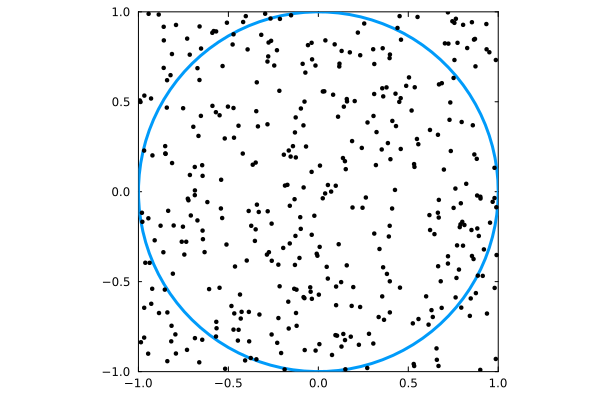

In [14]:
using Plots
using Distributions

# plot circle
circlepts = Plots.partialcircle(0, 2π, 100)
plot(circlepts, aspect_ratio=:equal, xlims=(-1, 1), ylims=(-1, 1), legend=false, lw=3, grid=false, frame=:box)

# plot darts
N = 400
d = Uniform(-1, 1)
scatter!(rand(d, N), rand(d, N), ms=2.5, color=:black)

### Basic Julia Implementation

In [15]:
function compute_pi(N)
    M = 0 # number of darts that landed in the circle
    for i in 1:N
        if sqrt(rand()^2 + rand()^2) < 1.0
            M += 1
        end
    end
    return 4 * M / N
end

compute_pi (generic function with 1 method)

In [16]:
compute_pi(10_000_000)

3.142104

### Tasks

1. Based on `compute_pi`, write a parallel version `compute_pi_parallel(N::Int)` that divides the work into `Threads.nthreads()` parallel tasks. The final estimate for π should be the average of the estimate of each task. 
    1. **Hint:** Be aware of false sharing, that is, make sure that every tasks operates locally and only shares the local result at the end.
    2. **Hint:** You may call the serial `compute_pi` in your code.
    3. **Hint:** If you want, implement two versions, one based on `@threads` and another using `@spawn`.

2. Benchmark and compare the serial and parallel variants.
    1. **Hint:** A reasonable value for $N$ could be `N = 10_000_000`.

In [17]:
using BenchmarkTools
using Base.Threads

In [18]:
function compute_pi_parallel_threads(N::Int)
    nt = nthreads()
    pis = zeros(nt)
    @threads for i in 1:nt
        pis[i] = compute_pi(ceil(Int, N / nt))
    end
    return sum(pis) / nt  # average
end

function compute_pi_parallel_spawn(N::Int)
    nt = nthreads()
    tasks = map(1:nt) do i
        @spawn compute_pi(ceil(Int, N / nt))
    end
    return sum(fetch.(tasks)) / nt  # gather results and compute average
end

@btime compute_pi(10_000_000) samples=5 evals=2
@btime compute_pi_parallel_threads(10_000_000) samples=5 evals=2
@btime compute_pi_parallel_spawn(10_000_000) samples=5 evals=2

  58.764 ms (0 allocations: 0 bytes)
  16.014 ms (22 allocations: 2.05 KiB)
  15.421 ms (35 allocations: 2.28 KiB)


3.141388

3. Write a function `compute_pi_multiple(Ns::Vector{Int})` which takes in a collection of values for $N$ (`Ns`) and **in serial** computes $\pi$ for all these values. The function should be **entirely serial** and based on `compute_pi`. Benchmark and compare to the previous variants.

In [19]:
function compute_pi_multiple(Ns::Vector{Int})
    pis = zeros(length(Ns))
    for i in 1:length(Ns)
        pis[i] = compute_pi(Ns[i])
    end
    return pis
end

some_Ns = [10, 100, 1000, 10_000, 100_000, 1_000_000, 2_000_000, 3_000_000, 4_000_000]

@btime compute_pi_multiple(some_Ns) samples=5 evals=2

  59.926 ms (1 allocation: 128 bytes)


9-element Vector{Float64}:
 2.0
 2.96
 3.0
 3.1868
 3.1442
 3.141592
 3.142662
 3.141302666666667
 3.140516

4. Write a function `compute_pi_multiple_parallel(Ns::Vector{Int})` which takes in a collection of values for $N$ (`Ns`) and **in parallel** computes $\pi$ for all these values. The function should still be based on the serial `compute_pi`. Benchmark and compare to the previous variants.
    1. **Hint:** You shouldn't use `@threads` here. Do you know why? Think about the input values and the resulting computational cost. You can also write a version with `@threads` and one with `@spawn` and compare the performance.

In [20]:
function compute_pi_multiple_parallel_threads(Ns::Vector{Int})
    pis = zeros(length(Ns))
    @threads for i in 1:length(pis)
        pis[i] = compute_pi(Ns[i])
    end
    return pis
end

function compute_pi_multiple_parallel_spawn(Ns::Vector{Int})
    tasks = map(Ns) do N
        @spawn compute_pi(N)
    end
    return fetch.(tasks)
end

some_Ns = [10, 100, 1000, 10_000, 100_000, 1_000_000, 2_000_000, 3_000_000, 4_000_000]

@btime compute_pi_multiple_parallel_threads($some_Ns) samples=5 evals=2
@btime compute_pi_multiple_parallel_spawn($some_Ns) samples=5 evals=2

  42.138 ms (23 allocations: 2.03 KiB)
  24.432 ms (63 allocations: 4.45 KiB)


9-element Vector{Float64}:
 3.2
 3.16
 3.192
 3.1108
 3.13844
 3.145224
 3.140584
 3.1420826666666666
 3.141743

5. Calculate $\pi$ estimates for the following $N$ values: `Ns = ceil.(Int, exp10.(range(1, stop=8, length=50)))`. Plot $\pi$ vs $N$ on a semi-log plot.

In [21]:
# N values (nothing todo here)
Ns = ceil.(Int, exp10.(range(1, stop=8, length=50)));

In [22]:
# Important: the resulting pi estimates should be stored in a variable named: pis
# ...
@time pis = compute_pi_multiple_parallel_spawn(Ns);

  0.673780 seconds (312 allocations: 23.391 KiB)


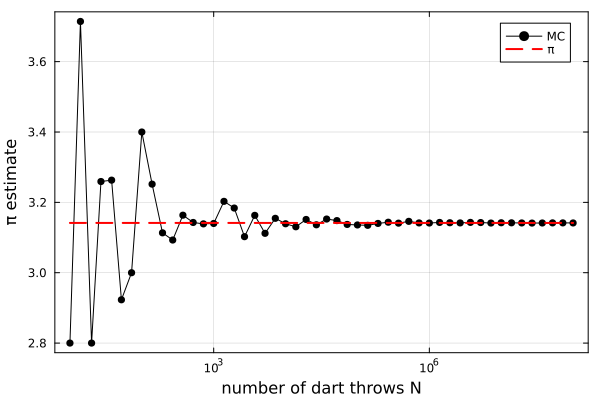

In [23]:
# Plotting (nothing todo here)
plot(Ns, pis, color=:black, marker=:circle, lw=1, label="MC", xscale=:log10, frame=:box)
plot!(x -> π, label="π", xscale=:log10, linestyle=:dash, color=:red, lw=2)
ylabel!("π estimate")
xlabel!("number of dart throws N")

6. **Bonus:** Try to write a function `compute_pi_multiple_nested_parallel(Ns::Vector{Int})` which computes $\pi$ for all given $N$ values using nested multithreading: Both the outer computation ("for each N in Ns") as well as the inner computation ("compute pi for a given N") should be parallelized. Benchmark and compare to the previous variants.

In [24]:
function compute_pi_multiple_nested_parallel_threads(Ns::Vector{Int})
    pis = zeros(length(Ns))
    @threads for i in 1:length(pis)
        pis[i] = compute_pi_parallel_threads(Ns[i])
    end
    return pis
end

function compute_pi_multiple_nested_parallel_spawn(Ns::Vector{Int})
    tasks = map(Ns) do N  # we could also use a for loop here
        @spawn compute_pi_parallel_spawn(N)
    end
    return fetch.(tasks)
end

some_Ns = [10, 100, 1000, 10_000, 100_000, 1_000_000, 2_000_000, 3_000_000, 4_000_000]

@btime compute_pi_multiple_nested_parallel_threads($some_Ns) samples=5 evals=2
@btime compute_pi_multiple_nested_parallel_spawn($some_Ns) samples=5 evals=2

# from above, for comparison
@btime compute_pi_multiple_parallel_spawn($some_Ns) samples=5 evals=2

  16.067 ms (220 allocations: 20.44 KiB)
  16.561 ms (369 allocations: 24.84 KiB)
  25.747 ms (63 allocations: 4.45 KiB)


9-element Vector{Float64}:
 2.4
 3.0
 3.18
 3.1696
 3.1428
 3.144092
 3.141194
 3.1429386666666668
 3.142537